# II A

In this task we are going to project the Iris dataset onto the two top principal components (PCs). We are first going to tranform the data, extract the top two principal components, and plot them against each other. Finally, we will determing which classes are lineary separable.

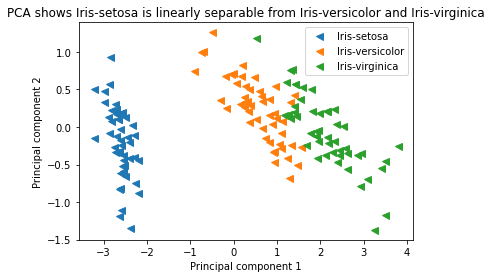

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the dataset and splitting it into features and targets
df=pd.read_csv(r"C:\Users\Yakov\Downloads\iris.data",header=None)
y=pd.DataFrame(df.iloc[:,-1])
X=df.iloc[:,:-1]
X_centred=X-np.mean(X,axis=0) # Centering the data

# Calculating the covariance matrix
df_m=np.asmatrix(X_centred)
cov_mat=np.cov(df_m.T)

eigVals, eigVec = np.linalg.eig(cov_mat) # Eigendecompositon of the covaraince matrix

# Sorting the eigenvalues and eigenvectors in descending order to determine the highest principal components 
idx = eigVals.argsort()[::-1] 
eigVals = eigVals[idx]
eigVec = eigVec[:,idx]

eigVec2 = eigVec[:,:2] # Selecting first 2 principal components

X_trans = df_m.dot(eigVec2) # Reducing the dimension of dataset by transforming the dataset 

X_pca2 = np.hstack((X_trans, y)) # Combining the transformed dataset with the targets

X_pca2 = pd.DataFrame(X_pca2) # Creating a pandas dataframe

# Setting up the column names
X_pca2.columns = ['x','y','target']
y = X_pca2.groupby('target')

# Creating a plot 
figure, axes = plt.subplots()
axes.margins(0.05)

for i, j in y:
    axes.plot(j.x, j.y, marker='<', linestyle='', ms=7, label=i)
    axes.set_title("PCA shows Iris-setosa is linearly separable from Iris-versicolor and Iris-virginica")
axes.legend()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.show()


We can clearly see that  Iris-setosa is linearly separable from Iris-versicolor and Iris-virginica

# II B

In this task we are going to design a multiclass perceptron and then test it for accuracy on 3 types of data:

    1) The original data
    2) Data comprised of 2 top PCs
    3) Data comprised of all 4 PCs


### Multiclass perceptron

In [206]:
from sklearn.utils import shuffle

class MulticlassPerceptron():
    
    
    def __init__(self, n_class=3, iterations=50):
    # This function initializes the number of classes and iterations.
        self.n_class = n_class
        self.iterations = iterations

    def weights(self):
    # This function initializes the weight matrix with rows equal to the number of classes and columns equal to the number of features
        self.weights = np.zeros((self.n_class, self.n_features+1))
    
    def fit(self, x, y):
    # This function iterates through the dataset until there are no errors and the weight matrix is in its "final" form        
        self.n_features = x.shape[1] # Setting n_features equal to the width of the dataset x       
        self.weights() # Initializing the weights matrix        
        x = np.append(x, np.ones((len(x), 1)), axis=1) # Adding a bias column of 1's to the dataset        
        for i in range(self.iterations): 
            update = self.train(x, y)
            if not update:
                update=update

    def train(self, x, y):
    # This function updates the weight matrix if error is 0. If the weight is updated, the functions returns True, and False otherwise      
        update = False # Default value of update is False
        # A loop to iterate through the dataset in order to update the weights. Since our method of computing loss is the Softmax function defined in lecture 14, we want our prediction to be the maximum index of the value  W.x_i can take. So for example if w_0.x_i or w_1.x_i or w_2.x_i is the max value, then the ourput is 0 or 1 or 2 respectively.
        # Every time we train the weights on a randomly shuffled dataset
        x, y = shuffle(x, y)
        for row, target in zip(x, y):
                prediction = np.argmax(np.dot(self.weights, row))
                # We check if prediction is equal to target and update 
                if prediction != target:
                    self.weights[prediction] -= row
                    self.weights[int(target)] += row
                    update =  True
        return update

    def predict(self, x):
    # A function to check the predcition values
        # Adding a bias column of 1's to the dataset
        x = np.append(x, np.ones((len(x), 1)), axis=1)
        prediction = np.array([])
        # Iterate throught the dataset and append the predicited value to the "predciton" array
        for row in x:
            res = np.dot(self.weights, row)
            prediction = np.append(prediction, np.argmax(res))

        return prediction

### Predicting using original data and principal components


We are now going to test our multiclass perceptron on our 3 different datasets decribed above. But we will first transform the data that was used in task 1. 

In [207]:
# Transforming the data to be used for classifying with 2 principal components
PCA_data2=X_pca2.to_numpy() # Transforming the dataset X_pca2 from task A to a numpy array

# Transforming the targets to numerical values
for i in PCA_data2:
    if i[-1]=="Iris-setosa":
        i[-1]=0
    elif i[-1]=="Iris-versicolor":
        i[-1]=1
    elif i[-1]=="Iris-virginica":
        i[-1]=2
#Transforming the data to type "float"
pca_y=PCA_data2[:,-1].astype(np.float)
pca_X2=PCA_data2[:,:-1].astype(np.float)



# Transforming the data to be used for classifying with 4 principal components
# Procedures from task A to extract the four principle components
eigVec4 = eigVec[:,:4] 
X_trans = df_m.dot(eigVec4)
X_pca4 = np.hstack((X_trans, target))
X_pca4 = pd.DataFrame(X_pca4)

PCA_data4=X_pca4.to_numpy() # Transforming the dataset X_pca4 to a numpy array

pca_X4=PCA_data4[:,:-1].astype(np.float) #Transforming the data to type "float"

We will now build a function which calculates the average accuracy of 200 perceptrons fitted to the same data. Note that the singular accuracy taken from one fit is the accuracy attained at the 50th iteration.

In [208]:
def accuracy(X_tr,y_tr,X_te,y_te):
    # A function which will calculate the accuracy of the predictions of the Perceptron
    """
    Arguments:
        X_tr: The training subset which contains features
        y_tr: The training subset which contains targets
        X_te: The testing subset which contains features
        y_te: The testing subset which contains targets
    """    
    accuracy=0 # Initializing the accuracy to 0 
    for i in range(200):
        p = MulticlassPerceptron(n_class=3) # Initialzing the Perceptron
        p.fit(X_tr, y_tr) # Fitting the Perceptron model onto the training data
        # We calculate the accuracy per 1 fit, and add it to the next accuracy so that at the end we take the average accuracy of all single accuracies.
        # Accuracy is calculated by summing up all the correctly predicted values and dividing by all values.
        accuracy+=(len(y_te)-len(np.where(p.predict(X_te) != y_te)[0]))/len(y_te)*100 
    total_accuracy=accuracy/200 # We calculate the average accuracy
    return total_accuracy

We are now going to calculate the accuracy of the Perceptron using the original dataset to classify our targets:

In [209]:
# We split the dataset into training and testing subsets, using the train_test_split method from the sklearn package
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, pca_y, test_size = 0.2, random_state=42)

# Calculating the accuracy
print("Accuracy of the Multiclass perceptron with the original data is "+"{:0.2f}".format(accuracy(X_train,y_train,X_test,y_test))+"%.")

Accuracy of the Multiclass perceptron with the original data is 91.93%.


Now we are going to classify the data in the 2d subspace defined by PCA:

In [210]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(pca_X2, pca_y, test_size = 0.2, random_state=42)

# Calculating the accuracy
print("Accuracy of the Multiclass Perceptron using 2 principal components is "+"{:0.2f}".format(accuracy(X_train,y_train,X_test,y_test))+"%.")

Accuracy of the Multiclass Perceptron using 2 principal components is 93.78%.


We are now going to use all four principal components:

In [211]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(pca_X4, pca_y, test_size = 0.2, random_state=42)

# Calculating the accuracy
print("Accuracy of the Multiclass Perceptron using 4 principal components is "+"{:0.2f}".format(accuracy(X_train,y_train,X_test,y_test))+"%.")

Accuracy of the Multiclass Perceptron using 4 principal components is 97.70%.


We can clearly see that the accuracy is better when we classify using the principal components. Moreover, the accuracy improves when including more principle components. This can be explained by the fact that every increment of princiapl components explains more variance. Although more principal components does not mean necessarily better accuracy, as you will see below.

# II C

In this task we are going to attempt to classify the data using a radial basis function Kernel, with which we are going to try to attain higher accuracy. We are going to need to create a non-linear version of PCA to project the data onto a high-dimensional subspace, by computing a nomalized Kernel matrix. We will then proceed to use that matrix as our dataset to classify the data by finding the most optimal parameters using a grid search.

### Computing the kernel matrix

We are now going to build a function which computes a normalized Kernel matrix.

In [212]:
from scipy import exp
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform


def kernel_pca(X, gamma, n_components):
    """
    Arguments:
        X: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: A free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.

    """
    # We compute ||x_i-x_j||^2 for all i<j<N, where N is the number of original observations and then we convert the vector-form distance vector to a square form distance matrix. (If we have N observations, we'll have an NxN matrix.)
    matrix_dist = squareform(pdist(X, 'sqeuclidean'))
    
    # Computing the NxN kernel matrix.
    K = exp(-gamma * matrix_dist)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    A = np.ones((N,N))/N
    K = K - A.dot(K) - K.dot(A) + A.dot(K).dot(A)
    
    # Computing eigenvalues and eigenvectors for the normalized matrix K
    eigVal, eigVec = eigh(K)

    # Computing PCc for the normalized matrix K
    K_pca = np.column_stack((eigVec[:,-i] for i in range(1,n_components+1)))

    return K_pca



### Grid search

To find the most optimal parameters, we will do a grid search. The grid search will iterate through every combination of gamma and the number of PCs and find the smallest amount of PCs (and then the smallest corresponding Gamma) which attain the best accuracy.

We will now calculate the Gamma range for our grid search.

In [232]:
X_centred=X_centred.to_numpy() # Transforming X_centred to numpy

# Calculating the variances of the features
var_list=[]
for i in range(X_centred.shape[1]):
    c=np.var(X_centred[:,i])
    var_list.append(c)
    
# Getting the minimum and maximum variance
min_var=min(var_list)
max_var=max(var_list)

# Calculating minimum and maximum gamma
gamma_min=1/(2*(max_var+0.05))
print(gamma_min)
gamma_max=1/(2*(min_var-0.05))
print(gamma_max)

# Setting the gamma range
gamma_range=[gamma_min,gamma_max]
print("Gamma range is: "+str(gamma_range))

0.15911279272510853
3.6562893051100307
Gamma range is: [0.15911279272510853, 3.6562893051100307]


We will now do a grid search to search for the best combination of PC's and gamma. We define our accuracy function to return the average of 5 accuracies for efficiency purposes.

In [237]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def accuracy(X_tr,y_tr,X_te,y_te):
    accuracy=0
    for i in range(5):
        p = MulticlassPerceptron(n_class=3)
        p.fit(X_tr, y_tr)
        accuracy+=(len(y_te)-len(np.where(p.predict(X_te) != y_te)[0]))/len(y_te)*100
    total_accuracy=accuracy/5
    return total_accuracy

def gridSearch(X,y,gamma_range):
    """
    Implementing a grid search to find the best combination of gamma and number of components.
    
    Input:
        1) X - Dataset from which we compute the normalized matrix K with the RBF kernel 
        2) gamma_range - an interval from which we will choose our gamma's. The interval is equal to
        [gamma_min,gamma_max], where gamma_min and gamma_max are equal to the specified values in CW specification
        3) increment
    
    """
    # As per CW specifications, we define the increment to be 0.1 
    increment=0.1
    max_pcas=X.shape[0] # Setting our maximum value of Principal components to loop through to be the length of the dataset
    gamma=min(gamma_range) # Initializing gamma to the minimum value from the range
    hm_dict=dict(gamma=[],n_pc=[],acc=[]) # Creating a dictionary for our heatmap
    # Double loop to go through every combination of parameters and append the accuracies to the dictionary with their corresponding hyperparameters
    while gamma<=max(gamma_range):
        for n_pca in range(5,max_pcas+1):
            hm_dict['gamma'].append("{:0.2f}".format(gamma))
            hm_dict['n_pc'].append(n_pca)
            K=kernel_pca(X,gamma,n_pca)
            X_train, X_test, y_train, y_test = train_test_split(K, y, test_size = 0.2, random_state=42)
            accu=accuracy(X_train,y_train,X_test,y_test)
            hm_dict['acc'].append(float("{:0.2f}".format(accu)))
        gamma+=increment
    # Here i'm going to create a list of combinations which get accuracy 100%, so that later on I can set the minimum value of that list to be my best combination of hyperparameters
    combinations=[]
    for i,k in enumerate(hm_dict['acc']):
        if k==100:
            combinations.append([float(hm_dict['gamma'][i]),float(hm_dict['n_pc'][i])])

    best_combination=min(combinations)
    return hm_dict,best_combination
    
    
heat_dict,best_param=gridSearch(X,pca_y,gamma_range)   



In [238]:
print("The best Gamma and number of principle components combination is: \nGamma= "+str(best_param[0])+" and number of PCs = "+str(best_param[1]))

The best Gamma and number of principle components combination is: 
Gamma= 0.16 and number of PCs = 7.0


We have chosen the minimal number of PCs and gamma combination which yielded the highest accuracy. 

We will now plot a heatmap representing the accuracy of each combination. The color of each cell indicates the accuracy attained by each combination. (red: minimum accuracy, light yellow: maximum accuracy).

Text(33.0, 0.5, 'Gamma')

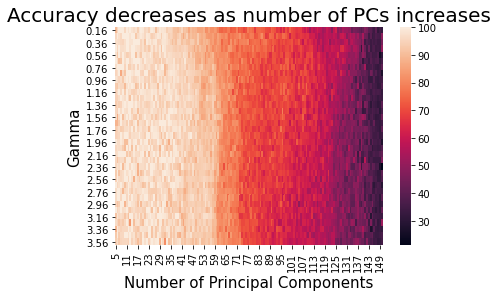

In [239]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Making the dictionary returned from our gridSearch function into a dataset which we'll plot
df = pd.DataFrame(heat_dict,columns=['gamma','n_pc','acc'])
df=df.pivot('gamma','n_pc','acc')

# Creating the heatmap
ax=sns.heatmap(df)
plt.title('Accuracy decreases as number of PCs increases', fontsize = 20)
plt.xlabel('Number of Principal Components', fontsize = 15)
plt.ylabel('Gamma', fontsize = 15)

We can see that as the number of principal components approaches the range after 60, accuracy starts to decrease. This can be explained by the fact that as the dimensions increase, the perceptron finds it harder to converge, since linear separability of the data becomes more scarce.